# Calculate posterior

In [1]:
import sys, os
import logging
import numpy as np
from scipy.stats import uniform, norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../")
from simulation.prior import get_grid
from inference.bayes import Posterior

## Setup

In [19]:
n = 10
n_events_for_expectation = 10000

In [20]:
filenames = [
    "alices_fix",
    "alices_mass_pre",
    "alices_align_pre",
    "alices_full_pre",
]
labels = ["Fix", "Mass", "Align", "Full"]

nmethods = len(filenames)
ncols = 2
nrows = (nmethods - 1) // ncols + 1

In [21]:
def prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * norm(-1.9, 0.1).pdf(beta).flatten()

In [22]:
def flat_prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * uniform(-2.5, 1.0).pdf(beta).flatten()

## Load data

In [23]:
theta_grid = get_grid()

In [24]:
llrs = []
for filename in filenames:
    llrs.append(np.load("../data/results/llr_{}_grid.npy".format(filename))[:,:n_events_for_expectation])

## Param grid

In [25]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Calculate posteriors

In [26]:
posteriors = []

for llr in llrs:
    bayes = Posterior(llr, theta_grid)
    posteriors.append(
        bayes.posterior_based_on_expected_llr(n, prior)
    )

In [27]:
posteriors_flatprior = []

for llr in llrs:
    bayes = Posterior(llr, theta_grid)
    posteriors_flatprior.append(
        bayes.posterior_based_on_expected_llr(n, flat_prior)
    )

## Plot posteriors

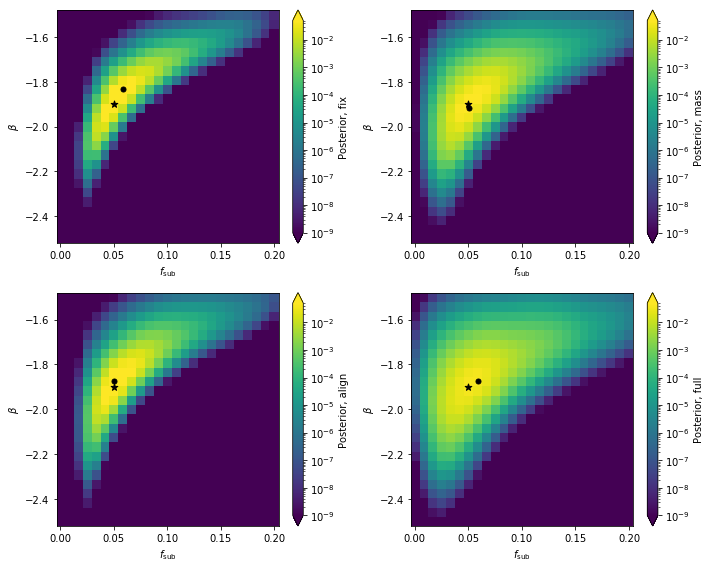

In [35]:
pmin, pmax = 1.e-9, 0.05
thresholds = [0.1]

fig = plt.figure(figsize=(5. * ncols, 4. * nrows))
ax_xs = []
ax_rs = []

for i, posterior in enumerate(posteriors):
    ax = plt.subplot(nrows, ncols, i + 1)

    i_mle = np.argmax(posteriors[i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(posteriors[i], pmin, pmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.LogNorm(vmin=pmin, vmax=pmax),
        cmap="viridis"
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    if False:
        cs = plt.contour(
            0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
            0.5 * (beta_edges[1:] + beta_edges[:-1]),
            z.reshape((resolution, resolution)),
            thresholds,
            colors="black",
            linewidths=1.,
            linestyles=["-" for _ in thresholds],
        )
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=25., color='black', marker='o')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'Posterior, '+ labels[i].lower())
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/posterior_2d.pdf")

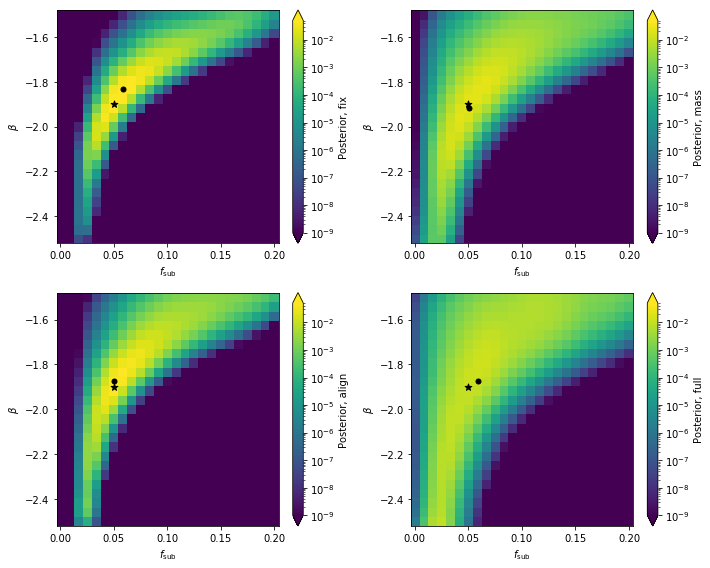

In [36]:
pmin, pmax = 1.e-9, 0.05
thresholds = [0.1]

fig = plt.figure(figsize=(5. * ncols, 4. * nrows))
ax_xs = []
ax_rs = []

for i, posterior in enumerate(posteriors):
    ax = plt.subplot(nrows, ncols, i + 1)

    i_mle = np.argmax(posteriors[i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(posteriors_flatprior[i], pmin, pmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.LogNorm(vmin=pmin, vmax=pmax),
        cmap="viridis"
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    if False:
        cs = plt.contour(
            0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
            0.5 * (beta_edges[1:] + beta_edges[:-1]),
            z.reshape((resolution, resolution)),
            thresholds,
            colors="black",
            linewidths=1.,
            linestyles=["-" for _ in thresholds],
        )
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=25., color='black', marker='o')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'Posterior, '+ labels[i].lower())
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/posterior_2d_flat_prior.pdf")

## 1D projections

In [51]:
def project(posterior):
    return np.sum(posterior.reshape((25,25)), axis=0)

In [52]:
posteriors_1d = [project(posterior) for posterior in posteriors]
posteriors_1d_flatprior = [project(posterior) for posterior in posteriors_flatprior]

In [61]:
def prep(edges, histo):
    edges_ = np.copy(edges)
    histo_ = np.copy(histo)
    edges_ = np.repeat(edges_, 2)[1:-1]
    histo_ = np.repeat(histo_, 2)
    return edges_, histo_


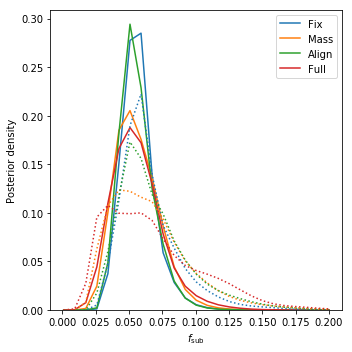

In [63]:
fig = plt.figure(figsize=(5,5))

for i, (posterior, label) in enumerate(zip(posteriors_1d, labels)):
    plt.plot(f_sub_1d, posterior, ls="-", label=label, c="C{}".format(i))

for i, (posterior, label) in enumerate(zip(posteriors_1d_flatprior, labels)):
    plt.plot(f_sub_1d, posterior, ls=":", c="C{}".format(i))
    
plt.legend()

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel("Posterior density")
#plt.yscale("log")
plt.ylim(0., None)

plt.tight_layout()
plt.savefig("../figures/posterior_1d.pdf")


## Check integral over posterior

In [64]:
for posteriors_ in [posteriors, posteriors_flatprior, posteriors_1d, posteriors_1d_flatprior]:
    for posterior in posteriors_:
        print(np.sum(posterior))
    print("")

0.9999999971562625
0.9999999996837958
0.9999999997503995
0.9999999998882961

0.9999999987547427
1.0000000000943188
1.0000000007021506
0.9999999998595811

0.9999999971562625
0.9999999996837959
0.9999999997503994
0.999999999888296

0.9999999987547428
1.0000000000943188
1.0000000007021506
0.9999999998595813

